# Анализ тарифных планов  и прибыли компании "Мегалайн".

1. [**Подготовка данных к анализу.**](#100101)
2. [**Данные об ушедших пользователях.**](#100102)
3. [**Потребности пользователей в минутах, сообщениях и минутах по тарифам месяц от месяца. Взаимосвязь между количеством пользователей и потребностями по тарифам.**](#100103)
4. [**Количество сделанных звонков по месяцам.**](#100104)
5. [**Количество израсходованных минут по месяцам.**](#100105)
6. [**Количество отправленных сообщений по месяцам.**](#100106)
7. [**Объем израсходованного интернет-трафика по месяцам.**](#100107)
8. [**Помесячная выручка с каждого пользователя.**](#100108)
9. [**boxplot, по количеству минут, сообщений и использованному трафику  в месяц.**](#100109)
10. [**Количество минут, сообщений и мегабайт достаточное большинству пользователей.**](#100110)
11. [**Срез пользователей по найденным показателям, изучаем изменения.**](#100111)
    * [11.1.Анализ данных по срезу (Количество минут, сообщений и мегабайт достаточное большинству пользователей).](#111100)
        * [11.1.2.Сколько минут разговора, сколько сообщений и какой объем интернет-трафика требуется пользователям каждого тарифа в месяц.](#111112)
    * [11.2.Дисперсия для каждого тарифа.](#111101)
    * [11.3.Распределение минут в тарифе Smart.](#111102)
    * [11.4.Распределение сообщений в тарифе Smart.](#111103)
    * [11.5.Распределение интернет-трафика в тарифе Smart.](#111104)
    * [11.6.Распределение минут в тарифе Ultra.](#111105)
    * [11.7.Распределение сообщений в тарифе Ultra.](#111106)
    * [11.8.Распределение интернет-трафика в тарифе Ultra.](#111107)
    
12. [**Проверка гипотез.**](#100112)
13. [**Проверим 1 гипотезу о том, что средняя выручка тарифов Smart и Ultra равны.**](#100113)
14. [**Проверим 2 гипотезу о том, что средняя выручка пользователей из Москвы равна средней выручке пользователей из других городов.**](#100114)
15. [**Общие выводы.**](#100115)

### 1. Подготовка данных к анализу <a id='100101'></a>

In [74]:
import pandas as pd
calls=pd.read_csv('calls.csv')
internet=pd.read_csv('internet.csv')
messages=pd.read_csv('messages.csv')
tariffs=pd.read_csv('tariffs.csv')
users=pd.read_csv('users.csv')

from nltk.stem import SnowballStemmer
from pymystem3 import Mystem
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
#pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
pd.options.mode.chained_assignment = None
pd.options.display.max_colwidth = 100
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500) 
pd.set_option('display.width', 1000)
import math
import numpy as np
import seaborn as sns
from scipy import stats as st

* *Информация о звонках:*

In [75]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [76]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [77]:
calls.isnull().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

* *Заменим тип столбца с датой на тип DateTime, округлим столбец с минутами, как округляет "Мегалайн" в большую сторону, и добавим столбец с месяцем:*

In [78]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['duration'] = calls['duration'].apply(np.ceil).astype(int)
calls['month'] = calls['call_date'].dt.month
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


* *Посмотрим количество строк с нулевыми значениями минут:*

In [79]:
cal_null = calls.query('duration == 0')
len(cal_null)

39613

Их более 19%, но придется их исключить, т.к. они помешают дальнейшему анализу.

In [80]:
call = calls.query('duration != 0')
call.head()

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9


* *Информация об интернет-трафике:*

In [81]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [82]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


* *Заменим тип столбца с датой на тип DateTime, округлим столбец с минутами и добавим столбец с месяцем:*

In [83]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype(int)
internet['month'] = internet['session_date'].dt.month
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,113,2018-11-25,1000,11
1,1000_1,1053,2018-09-07,1000,9
2,1000_2,1198,2018-06-25,1000,6
3,1000_3,551,2018-08-22,1000,8
4,1000_4,303,2018-09-24,1000,9


In [84]:
internet.isnull().sum()

id              0
mb_used         0
session_date    0
user_id         0
month           0
dtype: int64

Нулевых строк нет.

* *Информация о сообщениях:*

In [85]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [86]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [87]:
messages.isnull().sum()

id              0
message_date    0
user_id         0
dtype: int64

Нулевых строк нет.

* *Заменим тип столбца с датой на тип DateTime и добавим столбец с месяцем:*

In [88]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['month'] = messages['message_date'].dt.month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


* *Информация о тарифах:*

In [89]:
tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


* *исправим название колонок:*

In [90]:
tariffs = tariffs.rename(columns={'mg_per_month_included': 'mb_per_month_included'})
tariffs = tariffs.rename(columns={'rub_monthly_fee': 'rub_monthly_free'})

**Информация о пользователях:**

In [91]:
#проверим:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [92]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.3+ KB


In [93]:
users.isnull().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Количество клиентов компании - на первом месте Москва - 19,8%, второе Санкт-Петербург - 7,8%, остальные из различных городов России.

In [94]:
users['city'].value_counts(normalize=True).head(10)

Москва              0.198
Санкт-Петербург     0.078
Новосибирск         0.032
Омск                0.028
Казань              0.028
Уфа                 0.024
Екатеринбург        0.022
Краснодар           0.022
Ульяновск           0.022
Набережные Челны    0.022
Name: city, dtype: float64

Большинство (70,2%) пользуются тарифом Smart, и 29,8% тарифом Ultra.

In [95]:
users['tariff'].value_counts(normalize=True)

smart    0.702
ultra    0.298
Name: tariff, dtype: float64

* *Заменим тип данных в колонках с датами с object на datetime. А так же поставим дату за 2019 год заменив NaN в столбце churn_date, чтобы разграничить, тех, кто пользуется тарифом до сих пор с теми, кто отказался, но и не терять даты отказа.*

In [96]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = users['churn_date'].fillna('2019-08-05')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

#проверим:
#users.info()
#users.head()

### 2.Данные об ушедших пользователях: <a id='100102'></a>

38


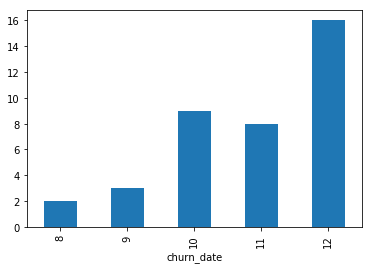

In [97]:
# по датам:
churn = users.query('churn_date != "2019-08-05"')
print(len(churn))
churn['churn_date'] = churn['churn_date'].dt.month
churn_date = churn.groupby(['churn_date'])['user_id'].count()
churn_date.plot(y='churn_date', kind='bar')

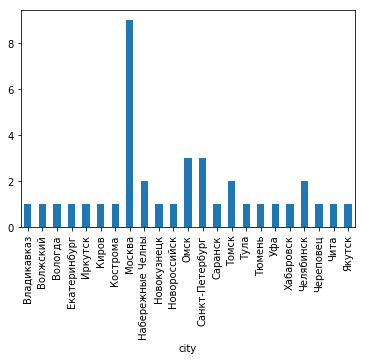

In [98]:
# по городам:
churn_city = churn.groupby(['city'])['user_id'].count()
churn_city.plot(y='city', kind='bar')

In [99]:
churn = churn.groupby('tariff')['user_id'].count()
churn

tariff
smart    23
ultra    15
Name: user_id, dtype: int64

* Отток пользователей составил 6%, больший отток наблюдается с тарифа Smart, городов - Москвы, Санкт-Петербурга, Омска, Томска, Челябинска и Набережных Челнов. 
* Отток начался в августе и достиг пика в декабре.

*******

* *Добавим столбцы с номером месяца в нужные таблицы, а так же добавим столбец с тарифным планом:*

In [100]:
df1 = users[['user_id', 'tariff']]
call = calls
call.set_index('user_id', inplace=True)
df1.set_index('user_id', inplace=True)
call = call.join([df1])
call.columns = ['id_call', 'call_date', 'duration', 'calls_month', 'tariff']

call.head()

,id_call,call_date,duration,calls_month,tariff
user_id,,,,,
1000,1000_0,2018-07-25,0,7,ultra
1000,1000_1,2018-08-17,0,8,ultra
1000,1000_2,2018-06-11,3,6,ultra
1000,1000_3,2018-09-21,14,9,ultra
1000,1000_4,2018-12-15,6,12,ultra


### 3.Посмотрим каковы потребности пользователей месяц от месяца: <a id='100103'></a>

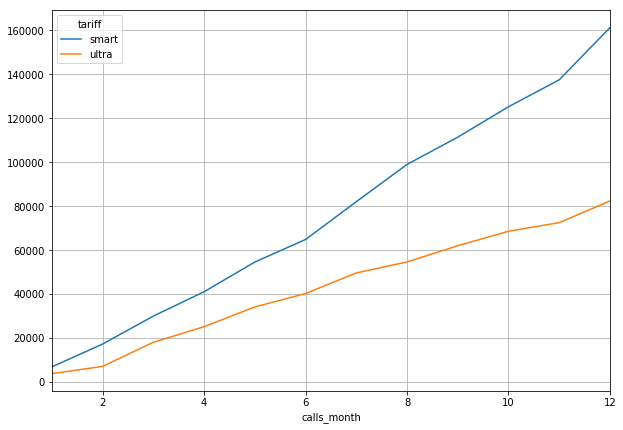

In [101]:
#потребности в количестве минут по тарифам:
c1 = call.pivot_table(index='calls_month', columns='tariff', values='duration', aggfunc='sum')
c1.plot(grid=True, figsize=(10, 7))

In [102]:
#c1.head(12)

Количество минут, неуклонно растет. Причем, на тарифе Smart гораздо сильнее.

In [103]:
#потребности в количестве сообщений по тарифам:
df2 = users[['user_id', 'tariff']]
message = messages
message.set_index('user_id', inplace=True)
df2.set_index('user_id', inplace=True)
message = message.join([df2])
message.columns = ['id_messages', 'message_date', 'messages_month', 'tariff']

message.head()

,id_messages,message_date,messages_month,tariff
user_id,,,,
1000,1000_0,2018-06-27,6,ultra
1000,1000_1,2018-10-08,10,ultra
1000,1000_2,2018-08-04,8,ultra
1000,1000_3,2018-06-16,6,ultra
1000,1000_4,2018-12-05,12,ultra


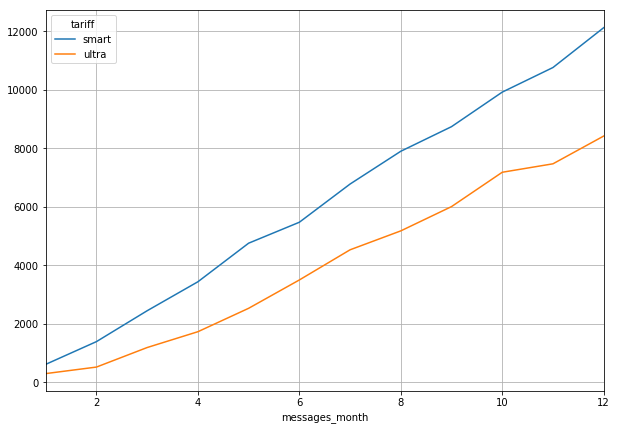

In [104]:
m1 = message.pivot_table(index='messages_month', columns='tariff', values='id_messages', aggfunc='count')
m1.plot(grid=True, figsize=(10, 7))

Количество сообщений так же растет, но более близко друг к другу.

In [105]:
df3 = users[['user_id', 'tariff']]
inter = internet

inter.set_index('user_id', inplace=True)
df3.set_index('user_id', inplace=True)
inter = inter.join([df3])
inter.columns = ['id_internet', 'mb_used', 'session_date', 'session_month', 'tariff']

#inter.head()

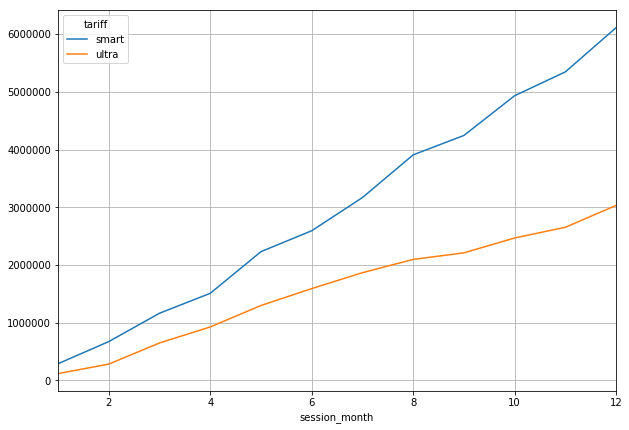

In [106]:
# потребность в количестве мегабайт по тарифам:
i1 = inter.pivot_table(index='session_month', columns='tariff', values='mb_used', aggfunc='sum')

i1.plot(grid=True, figsize=(10, 7))

С интернет_трафиком, всё так же как и с минутами. Все показатели растут, причем в тарифе Smart гораздо сильнее. Возможно из-за притока пользователей.

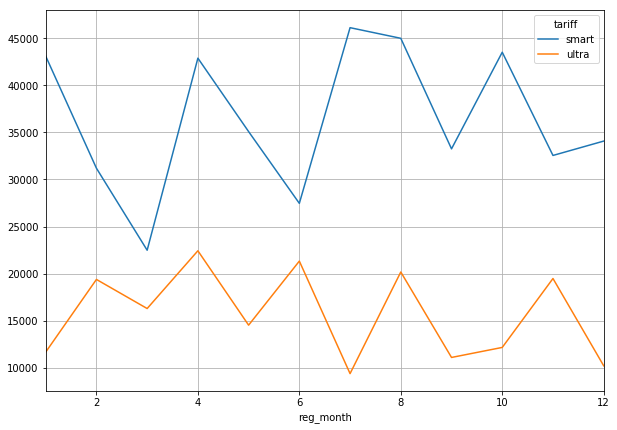

In [107]:
#взаимосвязь между количеством пользователей и потребностями по тарифам:
u1 = users
u1['reg_month'] = u1['reg_date'].dt.month
u1 = users.pivot_table(index='reg_month', columns='tariff', values='user_id', aggfunc='sum')
u1.plot(grid=True, figsize=(10, 7))

Видимой связи между количеством зарегистрировавшихся пользователей и ростом потребностей не прослеживается, значит потебление услуг действительно растёт. Так же обращают на себя внимание некоторые месяцы, например июнь и декабрь, когда количество пользователей тарифа Smart резко снижалось, но возрастали регистрации на Ultra, возможно пользователи переходили с одного тарифа на другой, из-за возросших потребностей. И наоборот в июле.

### 4.Количество сделанных звонков по месяцам: <a id='100104'></a>

(0, 37000)

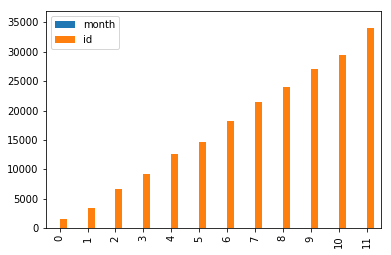

In [108]:
calls1 = pd.merge(calls, users, on='user_id', how='outer')
calls_month = calls1.pivot_table(index='month', values='id', aggfunc='count').reset_index()
calls_month.plot(kind='bar')
plt.ylim(0, 37000)

### 5.Количество израсходованных минут по месяцам: <a id='100105'></a>

(0, 260000)

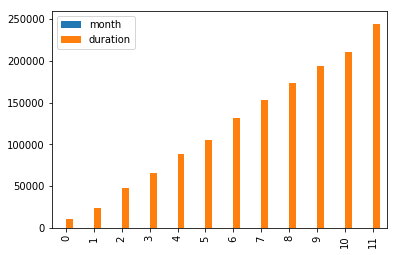

In [147]:
minutes_month = calls1.pivot_table(index='month', values='duration', aggfunc='sum').reset_index()
minutes_month.plot(kind='bar')
plt.ylim(0, 260000)

### 6. Количество отправленных сообщений по месяцам: <a id='100106'></a>

(0, 25000)

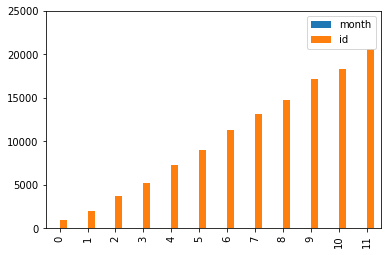

In [110]:
messages1 = pd.merge(messages, users, on='user_id', how='outer')
message_month = messages1.pivot_table(index='month', values='id', aggfunc='count').reset_index()
message_month.plot(kind='bar')
plt.ylim(0, 25000)

### 7. Объем израсходованного интернет-трафика по месяцам: <a id='100107'></a>

(0, 10000000)

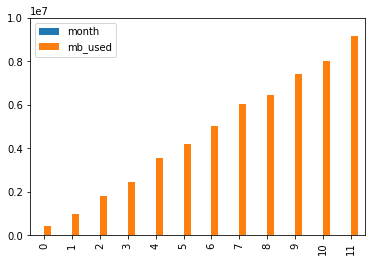

In [111]:
internet1 = pd.merge(internet, users, on='user_id', how='outer')
megabytes_month = internet1.pivot_table(index='month', values='mb_used', aggfunc='sum').reset_index()
megabytes_month.plot(kind='bar')
plt.ylim(0, 10000000)

### 8. Посчитаем помесячную выручку с каждого пользователя: <a id='100108'></a>

In [148]:
pivot_messages = pd.pivot_table(messages, index=['user_id', 'month'], values='id', aggfunc='count').reset_index()
pivot_calls = pd.pivot_table(calls, index=['user_id', 'month'], values='duration', aggfunc='sum').reset_index()
pivot_internet = pd.pivot_table(internet, values='mb_used', index=['user_id', 'month'], aggfunc='sum').reset_index()
#pivot_internet

In [149]:
result_messages = pd.merge(users, pivot_messages, on='user_id', how='outer')
result_calls = pd.merge(users, pivot_calls, on='user_id', how='outer')
result_internet = pd.merge(users, pivot_internet, on='user_id', how='outer')

In [150]:
result_v = pd.merge(pd.merge(result_calls, result_messages, on=['user_id', 'city', 'tariff', 'month'], how='outer'), result_internet, on=['user_id', 'city', 'tariff', 'month'], how='outer')
result_v = result_v[['user_id', 'city', 'tariff', 'month', 'duration', 'id', 'mb_used']]
result_v.columns = ['user_id', 'city', 'tariff', 'month', 'duration', 'id_messages', 'mb_used']
result_v = result_v.fillna(0)
#result_v
#result_internet

tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})
result_costs = pd.merge(result_v, tariffs, on='tariff', how='outer')

result_costs['over_duration'] = (result_costs['duration'] - result_costs['minutes_included']) * result_costs['rub_per_minute']
result_costs.loc[result_costs['over_duration'] < 0, 'over_duration'] = 0

result_costs['over_messages'] = (result_costs['id_messages'] - result_costs['messages_included']) * result_costs['rub_per_message']
result_costs.loc[result_costs['over_messages'] < 0, 'over_messages'] = 0

result_costs['over_mb'] = ((result_costs['mb_used'] - result_costs['mb_per_month_included']) / 1024) * result_costs['rub_per_gb']
result_costs.loc[result_costs['over_mb'] < 0, 'over_mb'] = 0

result_costs['value'] = result_costs['over_duration'] + result_costs['over_messages'] + result_costs['over_mb'] + result_costs['rub_monthly_free']

result_costs = result_costs[['user_id', 'city', 'tariff', 'month', 'duration', 'over_duration', 'id_messages', 'over_messages', 'mb_used', 'over_mb', 'value']]
result_costs['value'] = result_costs['value'].astype(int)
result_costs['month'] = result_costs['month'].astype(int)
result_costs['mb_used'] = result_costs['mb_used'].astype(int)
result_costs['id_messages'] = result_costs['id_messages'].astype(int)
result_costs['duration'] = result_costs['duration'].astype(int)
result_costs.head()

,user_id,city,tariff,month,duration,over_duration,id_messages,over_messages,mb_used,over_mb,value
0,1000,Краснодар,ultra,5,159,0.0,22,0.0,2256,0.0,1950
1,1000,Краснодар,ultra,6,172,0.0,60,0.0,23257,0.0,1950
2,1000,Краснодар,ultra,7,340,0.0,75,0.0,14016,0.0,1950
3,1000,Краснодар,ultra,8,408,0.0,81,0.0,14070,0.0,1950
4,1000,Краснодар,ultra,9,466,0.0,57,0.0,14581,0.0,1950


### 9. Построим графики boxplot, по количеству минут, сообщений и использованному трафику  в месяц: <a id='100109'></a>

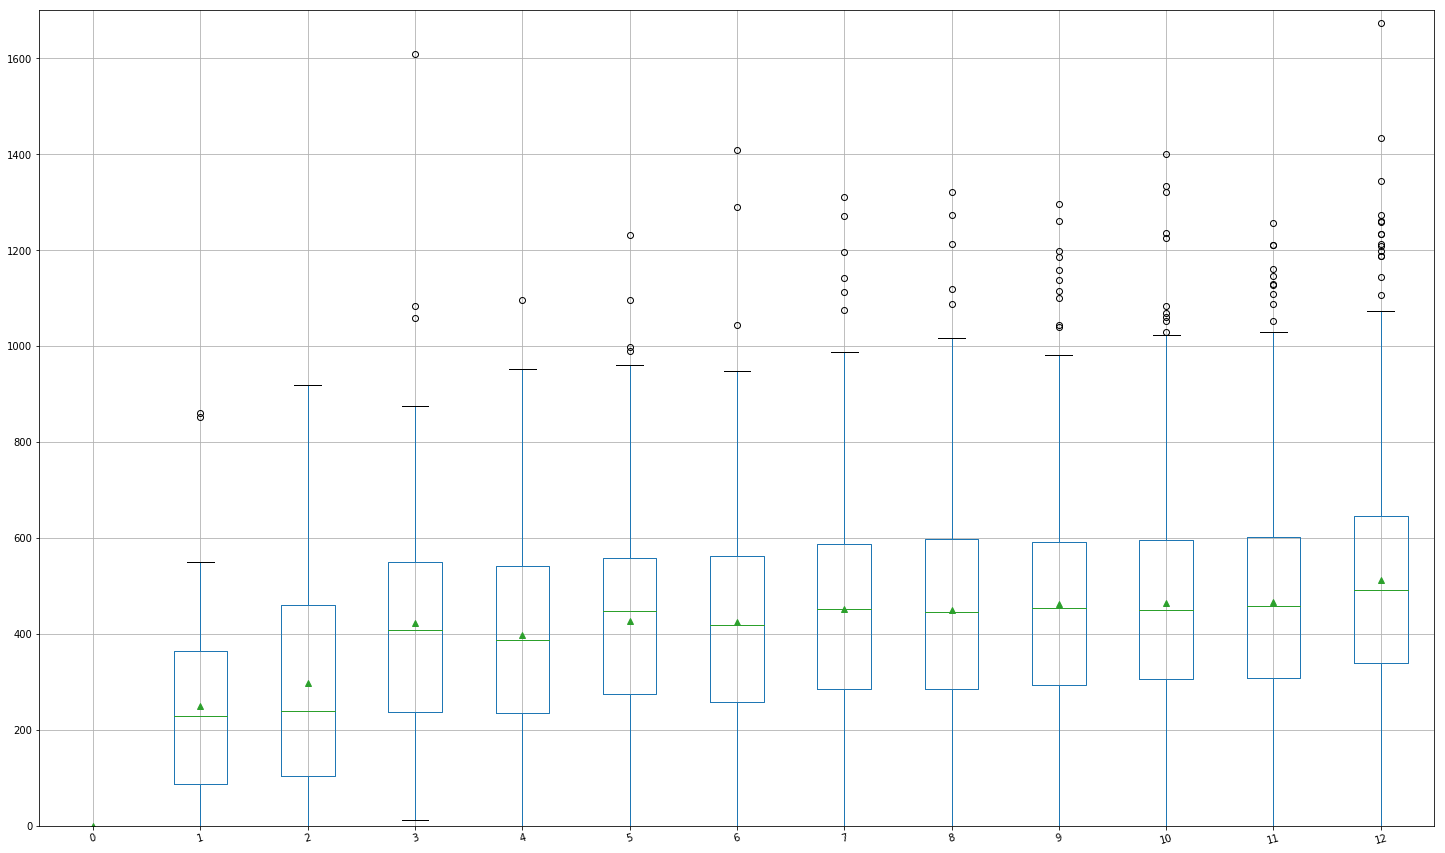

In [151]:
#минуты:
result_costs_minutes = result_costs.pivot_table(index='user_id', columns='month', values='duration', aggfunc='sum')
plot11 = result_costs_minutes.boxplot(showmeans=True, rot='15', figsize=(25, 15))
lim = plot11.set_ylim(0, 1700)

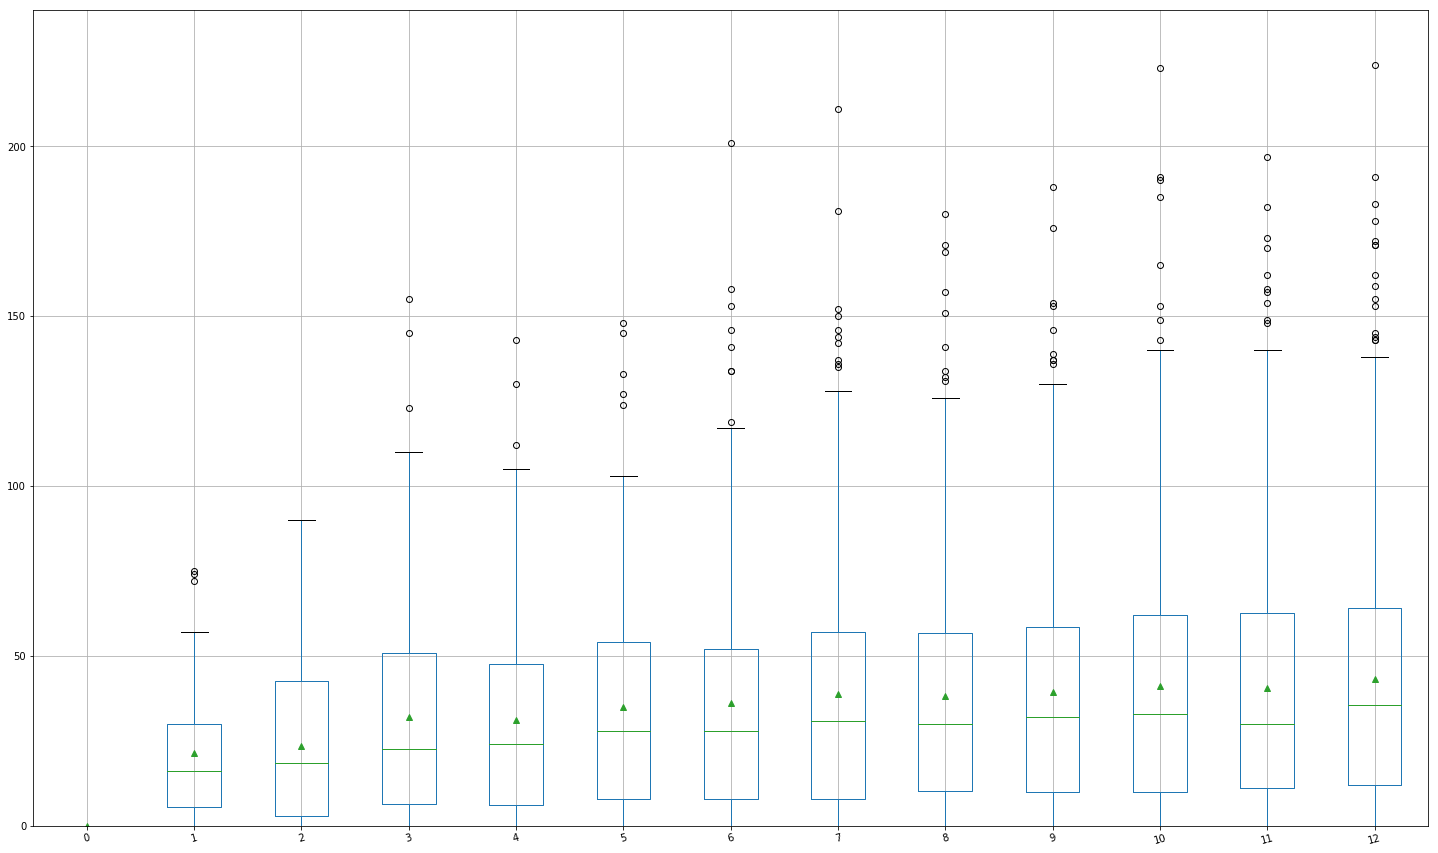

In [152]:
#сообщения:
result_costs_messages = result_costs.pivot_table(index='user_id', columns='month', values='id_messages', aggfunc='sum')
plot12 = result_costs_messages.boxplot(showmeans=True, rot='15', figsize=(25, 15))
lim = plot12.set_ylim(0, 240)

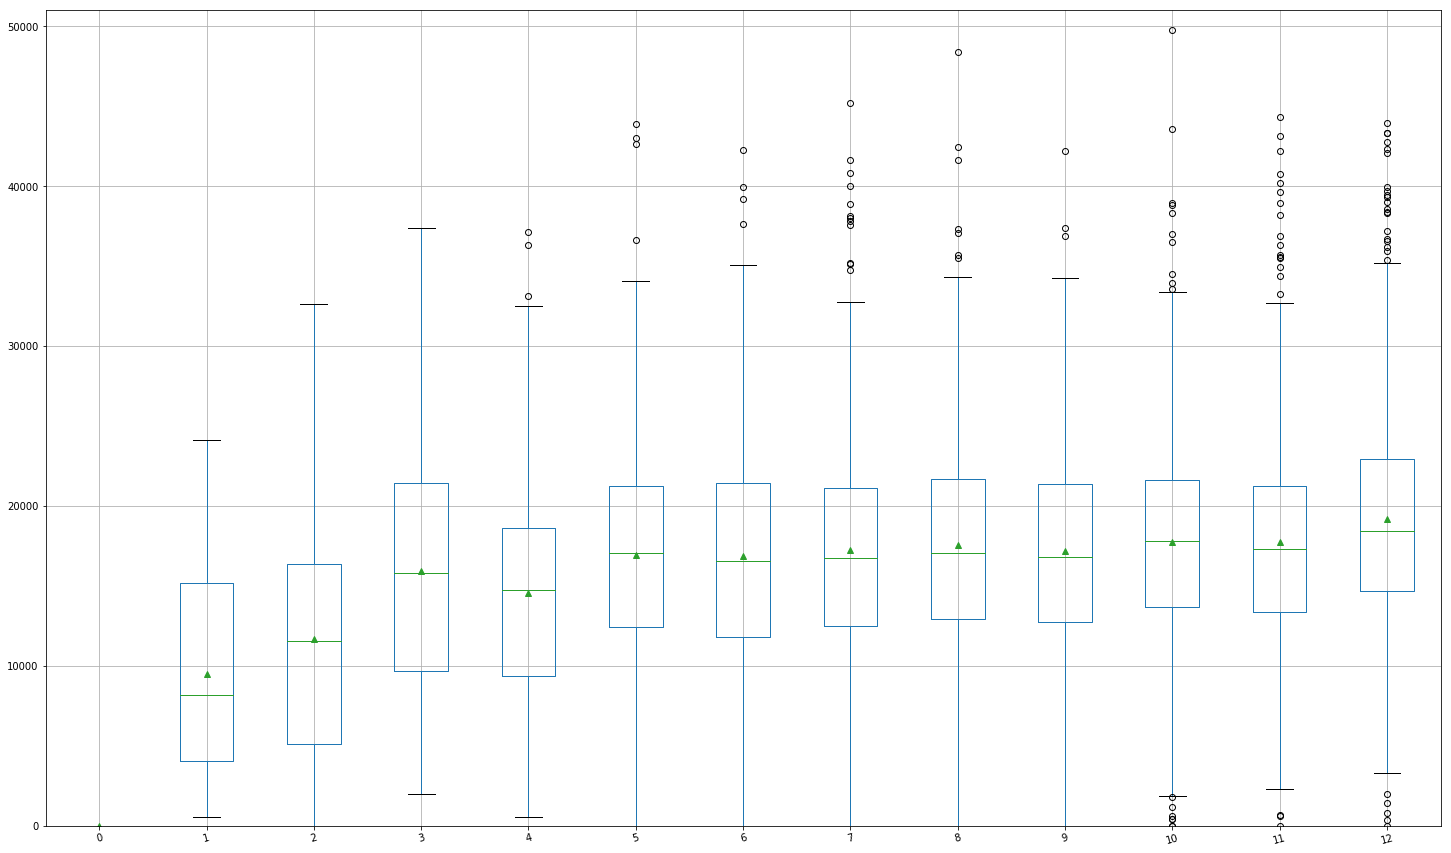

In [153]:
#мегабайты:
result_costs_internet = result_costs.pivot_table(index='user_id', columns='month', values='mb_used', aggfunc='sum')
plot12 = result_costs_internet.boxplot(showmeans=True, rot='15', figsize=(25, 15))
lim = plot12.set_ylim(0, 51000)

### 10. Количество минут, сообщений и мегабайт дстаточное большинству пользователей. <a id='100110'></a>

* *сделаем выборку по правилу трёх сигм:*

In [118]:
#result_costs

In [119]:
result_costs.describe()

,user_id,month,duration,over_duration,id_messages,over_messages,mb_used,over_mb,value
count,3295.000000,3295.000000,3295.000000,3295.000000,3295.000000,3295.000000,3295.000000,3295.000000,3295.000000
mean,1251.238543,8.112898,440.152049,84.436115,37.340212,11.770561,16804.084674,399.106823,1476.780577
std,144.487124,3.145336,248.928542,216.933921,36.190045,34.150772,7945.850058,644.668975,783.979202
min,1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,550.000000
25%,1125.000000,6.000000,272.000000,0.000000,7.000000,0.000000,12006.000000,0.000000,676.000000
50%,1251.000000,9.000000,437.000000,0.000000,29.000000,0.000000,16803.000000,0.000000,1544.000000
75%,1378.000000,11.000000,584.000000,0.000000,56.000000,0.000000,21313.000000,656.909180,1950.000000
max,1499.000000,12.000000,1673.000000,2805.000000,224.000000,279.000000,49789.000000,4541.015625,6711.000000


* *Возьмем значения для правила трех сигм из таблицы describe выше:*

In [155]:
quiz_top_minut = 440 + 3*249 
print('Минут достаточно большинству пользователей:', quiz_top_minut)

Минут достаточно большинству пользователей: 1187


In [156]:
quiz_top_messages = 37 + 3*36 
print('Сообщений достаточно большинству пользователей:', quiz_top_messages)

Сообщений достаточно большинству пользователей: 145


In [157]:
quiz_top_mb = 16804 + 3*7946 
print('Мегабайт достаточно большинству пользователей:', quiz_top_mb)

Мегабайт достаточно большинству пользователей: 40642


### 11. Срез пользователей по найденным показателям: <a id='100111'></a>

In [158]:
selection_result_costs = result_costs.query('duration < 1187 and id_messages < 145 and mb_used < 40642')
#selection_result_costs

После среза таблица сократилась всего на 0,3%, подавляющее большинство значений попало в срез.

* *Посмотрим как изменились основные показатели:*

In [159]:
selection_result_costs.describe()

,user_id,month,duration,over_duration,id_messages,over_messages,mb_used,over_mb,value
count,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000
mean,1251.726079,8.076923,430.217949,86.120075,35.115697,12.114447,16485.495310,395.323646,1446.091620
std,145.141677,3.156093,231.745188,214.373811,32.179525,34.599085,7568.577196,639.483412,762.550353
min,1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,550.000000
25%,1123.000000,6.000000,271.250000,0.000000,7.000000,0.000000,11910.500000,0.000000,657.000000
50%,1253.000000,9.000000,432.000000,0.000000,28.000000,0.000000,16644.500000,0.000000,1479.000000
75%,1380.750000,11.000000,576.000000,0.000000,54.000000,0.000000,21041.250000,654.492188,1950.000000
max,1499.000000,12.000000,1186.000000,1932.000000,144.000000,279.000000,40210.000000,4541.015625,6711.000000


Все показатели снизились немного и равномерно, кроме общего дохода, здесь среднее и медиана приблизились к друг другу.

### 11.1. Анализ данных по срезу (Количество минут, сообщений и мегабайт достаточное большинству пользователей). <a id='111100'></a>

### 11.1.2. Узнаем, сколько минут разговора, сколько сообщений и какой объем интернет-трафика требуется пользователям каждого тарифа в месяц: <a id='111112'></a>

In [160]:
smart = selection_result_costs.query('tariff == "smart"')
smart.describe()

,user_id,month,duration,over_duration,id_messages,over_messages,mb_used,over_mb,value
count,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000
mean,1246.420544,8.161984,408.315189,120.900790,32.637840,17.007024,15871.275680,529.086987,1216.709833
std,145.966982,3.136006,196.795685,245.596013,28.340255,39.969081,6281.035654,700.815114,782.731624
min,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,550.000000
25%,1121.000000,6.000000,273.250000,0.000000,9.000000,0.000000,12404.000000,0.000000,550.000000
50%,1239.000000,9.000000,416.000000,0.000000,27.000000,0.000000,16333.000000,190.039062,941.500000
75%,1376.000000,11.000000,542.000000,126.000000,50.000000,0.000000,19993.000000,904.882812,1649.000000
max,1499.000000,12.000000,1144.000000,1932.000000,143.000000,279.000000,38610.000000,4541.015625,6711.000000


In [161]:
selection_minut = 408.3 + 3*196.8 
print('Минут достаточно большинству пользователей в тарифе Smart:', selection_minut)

Минут достаточно большинству пользователей в тарифе Smart: 998.7


In [162]:
selection_message = 32.6 + 3*28.3
print('Сообщений достаточно большинству пользователей в тарифе Smart:', selection_message) 

Сообщений достаточно большинству пользователей в тарифе Smart: 117.5


In [163]:
selection_mb = 15871.2 + 3*6281
print('Мегабайт достаточно большинству пользователей в тарифе Smart:', selection_mb) 

Мегабайт достаточно большинству пользователей в тарифе Smart: 34714.2


In [164]:
ultra = selection_result_costs.query('tariff == "ultra"')
ultra.describe()

,user_id,month,duration,over_duration,id_messages,over_messages,mb_used,over_mb,value
count,920.000000,920.000000,920.000000,920.0,920.000000,920.0,920.000000,920.000000,920.000000
mean,1264.863043,7.866304,484.451087,0.0,41.251087,0.0,18006.356522,64.113982,2014.060870
std,142.306757,3.197278,294.516246,0.0,39.489768,0.0,9913.480872,227.023341,226.899518
min,1000.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1950.000000
25%,1126.000000,6.000000,259.000000,0.0,3.000000,0.0,10547.000000,0.000000,1950.000000
50%,1281.000000,8.000000,493.500000,0.0,31.000000,0.0,17869.000000,0.000000,1950.000000
75%,1382.000000,11.000000,708.250000,0.0,70.000000,0.0,25234.500000,0.000000,1950.000000
max,1495.000000,12.000000,1186.000000,0.0,144.000000,0.0,40210.000000,1390.136719,3340.000000


In [165]:
selection_minut2 = 484.4 + 3*294.5
print('Минут достаточно большинству пользователей в тарифе Ultra:', selection_minut2)

Минут достаточно большинству пользователей в тарифе Ultra: 1367.9


In [166]:
selection_message2 = 41.2 + 3*39.5
print('Сообщений достаточно большинству пользователей в тарифе Ultra:', selection_message2) 

Сообщений достаточно большинству пользователей в тарифе Ultra: 159.7


In [167]:
selection_mb2 = 18006.3 + 3*9913.4
print('Мегабайт достаточно большинству пользователей в тарифе Ultra:', selection_mb2) 

Мегабайт достаточно большинству пользователей в тарифе Ultra: 47746.5


### 11.2. Посчитаем дисперсию для каждого тарифа: <a id='111101'></a>

In [133]:
h1 = smart[['duration']]
h2 = smart[['id_messages']]
h3 = smart[['mb_used']]

In [168]:
variance_minut_s = np.var(h1)
variance_message_s = np.var(h2)
variance_mb_s = np.var(h3)
print('Дисперсия тарифа Smart (минуты)', variance_minut_s)
print('Дисперсия тарифа Smart (сообщения)', variance_message_s)
print('Дисперсия тарифа Smart (мегабайты)', variance_mb_s)

Дисперсия тарифа Smart (минуты) duration    38711.540691
dtype: float64
Дисперсия тарифа Smart (сообщения) id_messages    802.817479
dtype: float64
Дисперсия тарифа Smart (мегабайты) mb_used    3.943409e+07
dtype: float64


In [169]:
h4 = ultra[['duration']]
h5 = ultra[['id_messages']]
h6 = ultra[['mb_used']]

In [170]:
variance_minut_u = np.var(h4)
variance_message_u = np.var(h5)
variance_mb_u = np.var(h6)
print('Дисперсия тарифа Ultra (минуты)', variance_minut_u)
print('Дисперсия тарифа Ultra (сообщения)', variance_message_u)
print('Дисперсия тарифа Ultra (мегабайты)', variance_mb_u)

Дисперсия тарифа Ultra (минуты) duration    86645.536738
dtype: float64
Дисперсия тарифа Ultra (сообщения) id_messages    1557.746738
dtype: float64
Дисперсия тарифа Ultra (мегабайты) mb_used    9.817028e+07
dtype: float64


### 11.3. Распределение минут в тарифе Smart. <a id='111102'></a>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000002965CB00>]],
      dtype=object)

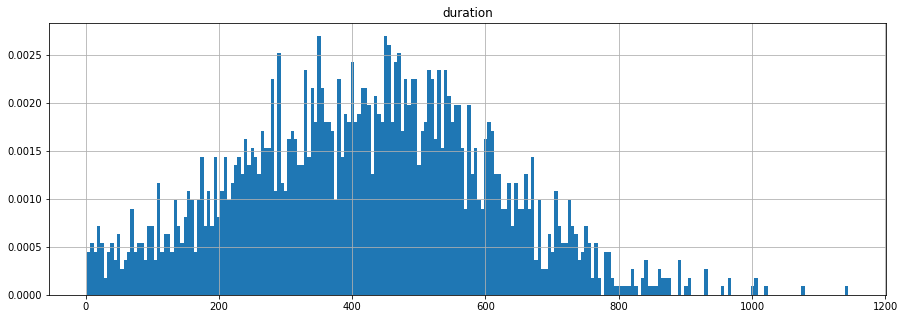

In [171]:
h_1 = h1.query('duration != 0')
h_1.hist(density=True, bins=228, figsize=(15, 5))

После того как отбросили нули в данных о проговоренных минутах, распределение минут в тарифе Smart бриблизилось к нормальному, т.е. по ним можно с большой долей вероятности судить о генеральной совокупности данных.

### 11.4. Распределение сообщений в тарифе Smart. <a id='111103'></a>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000286AE898>]],
      dtype=object)

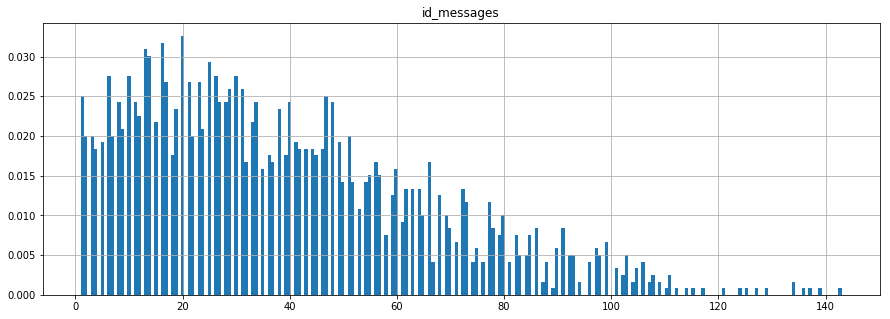

In [172]:
h_2 = h2.query('id_messages != 0')
h_2.hist(density=True, bins=228, figsize=(15, 5))

График несимметричен похож на распределение Пуассона

### 11.5. Распределение интернет-трафика в тарифе Smart. <a id='111104'></a>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000286E9A20>]],
      dtype=object)

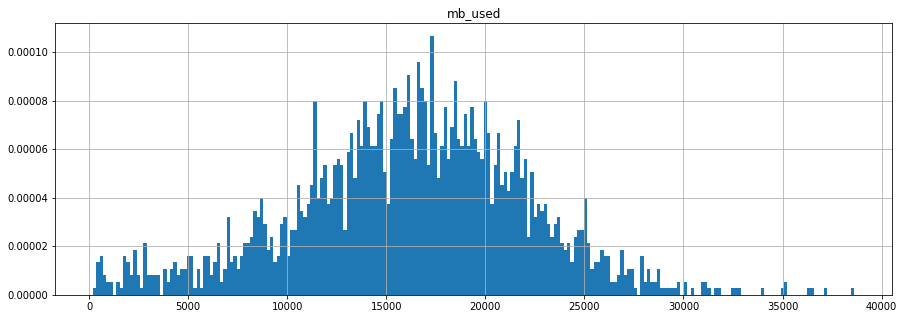

In [173]:
h_3 = h3.query('mb_used != 0')
h_3.hist(density=True, bins=228, figsize=(15, 5))

После того как отбросили нули в данных об использованном интернет-трафике, распределение мегабайт в тарифе Smart бриблизилось к нормальному, т.е. по ним можно с большой долей вероятности судить о генеральной совокупности данных

### 11.6. Распределение минут в тарифе Ultra. <a id='111105'></a>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000026F2AD68>]],
      dtype=object)

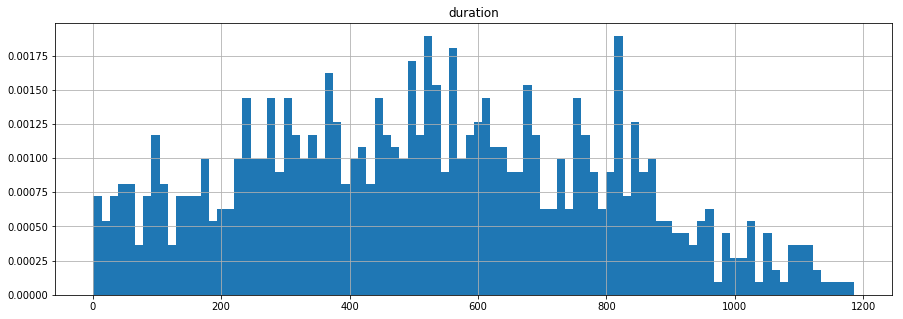

In [140]:
h_4 = h4.query('duration != 0')
h_4.hist(density=True, bins=92, figsize=(15, 5))

### 11.7. Распределение сообщений в тарифе Ultra. <a id='111106'></a>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001B744D30>]],
      dtype=object)

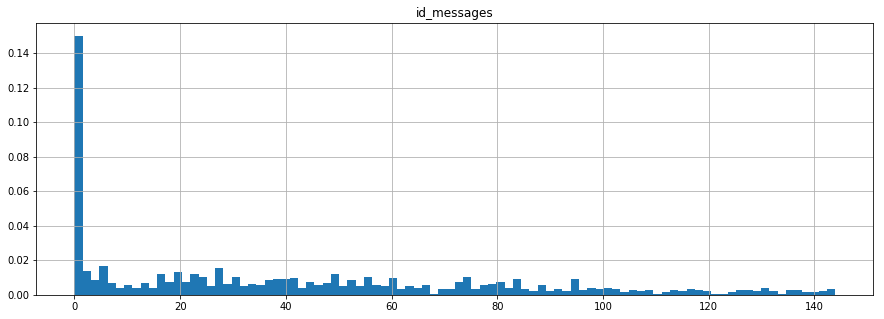

In [141]:
h_5 = h5.query('id_messages != 0')
h5.hist(density=True, bins=92, figsize=(15, 5))

### 11.8. Распределение интернет-трафика в тарифе Ultra. <a id='111107'></a>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000026A7F240>]],
      dtype=object)

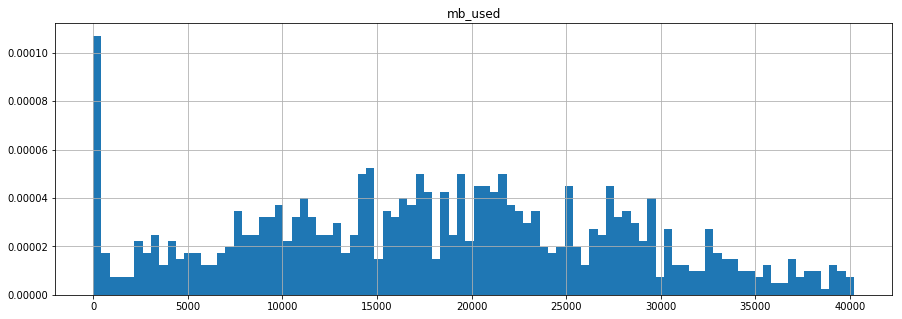

In [174]:
h_6 = h6.query('mb_used != 0')
h6.hist(density=True, bins=92, figsize=(15, 5))

Данные о сообщениях требуют дополнительного исследования и причины появления нулевых значений аналогично.

### 12. Проверка гипотез. <a id='100112'></a>

In [175]:
h7 = smart['value']
h8 = ultra['value']
variance_v_s = np.var(h7)
variance_v_u = np.var(h8)
print('Дисперсия доходов тарифа Smart', variance_v_s)
print('Дисперсия доходов тарифа Ultra', variance_v_u)

Дисперсия доходов тарифа Smart 612399.8442492224
Дисперсия доходов тарифа Ultra 51427.43107750426


### 13. Проверим 1 гипотезу: <a id='100113'></a>

* Н0 - средняя выручка Smart = средней выручке Ultra
* Н1 - средние выручки тарифов различаются

In [176]:
alpha = .05
results = st.ttest_ind(
    h7,
    h8)
results.pvalue

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую') 

Отвергаем нулевую гипотезу


**Выручка пользователей двух тарифов отличается.**

### 14. Проверим 2 гипотезу: <a id='100114'></a>

* Н0 - средняя выручка пользователей из Москвы равна средней выручке пользователей из других городов
* Н1 - средние выручки регионов и Москвы различаются

In [177]:
#сделаем срезы для Москвы и регионов:
moscow = selection_result_costs.query('city == "Москва"')
regions = selection_result_costs.query('city != "Москва"')

#возьмем значения столбца доход:
h9 = moscow['value']
h10 = regions['value']

In [178]:
alpha = .05
result = st.ttest_ind(
    h9,
    h10)
result.pvalue

if (result.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую') 

Не получилось отвергнуть нулевую


**Средняя выручка от местоположения не зависит.**

### 15. Общие выводы. <a id='100115'></a>

* **Количество клиентов компании: на первом месте Москва - 19,8%, второе Санкт-Петербург - 7,8%, остальные из других городов России.**
* **Большинство (70,2%) пользуются тарифом Smart, а 29,8% тарифом Ultra.**
* **Были нулевые строки в столбце "звонки" около 19% - это довольно много и требует дополнительного исследования!**
* **Отток пользователей составил 7,6%, больший отток наблюдается с тарифа Smart (60%), городов - Москвы (23% - т.к. соотношение пользователей общего количества схоже, зависимости оттока от города не прослеживается), Санкт-Петербурга, Омска, Томска, Челябинска и Набережных Челнов. Отток начался в августе и достиг пика в декабре (42%).**
* **Так же обращают на себя внимание некоторые месяцы, например июнь и декабрь, когда количество пользователей тарифа Smart резко снижалось, но возрастали регистрации на Ultra, возможно пользователи переходили с одного тарифа на другой, из-за возросших потребностей. И наоборот в июле.**
* **Количество минут проговоренных пользователями  и количество потраченных мегабайт трафика растет месяц от месяца, причем с притоком пользователей это не связано. Выделяется февраль - март. Количество отправленных сообщений растет более равномерно.**
* **Выручка (по общим данным по выборке без выбросов) составила: среднее = 1446 руб., медиана = 1479 руб.**
* **Выручка в тарифе Smart: среднее = 1216 руб., медиана = 941 руб., большое различие, возможно каким-то пользователям нужно порекомендовать тариф Ultra во избежание оттока. Большинству пользователей требуется 999 минут, 117 сообщений и почти 34 Гб трафика в месяц, что значительно превышает возможности тарифа.**
* **Выручка в тарифе Ultra: среднее = 2014 руб., медиана - 1950, редкие пользователи превышают лимиты тарифа. Большинству пользователей достаточно 1368 минут, 160 сообщений и 46,6 Гб интернет-трафика в месяц, потребность в интернет-трафике так же превышает возможности тарифа.**
* **Возможно стоит ввести 3-й тариф для возможного перехода пользователей Smart, во избежание оттока! И возможно ввести пакеты интернет-трафика.**
* **Так же были рассмотрены гипотезы. Нулевую гипотезу гипотезу в обоих случаях формулировала, чтобы выручки были равны.  Выводы: средняя выручка тарифов различается, и не зивисит от региона.**